In [ ]:
import tensorflow as tf
import os #Used to navigate file structures

In [ ]:
os.path.join('data','periodontal')

'data/periodontal'

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [ ]:
image_exts = ['png']
data_dir = 'data'

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img = cv2.imread(image_path, cv2.COLOR_RGB2BGR)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

Issue with image data/non_periodontal/.ipynb_checkpoints


# New Section

In [ ]:
import numpy as np

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size = 10, image_size = (224,224))

Found 97 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next() #Get another batch from iterator

In [ ]:
batch[0].shape

(10, 224, 224, 3)

In [ ]:
#Class 1 (0) = no periodontal
#Class 2 (1) = periodontal
batch[1]

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

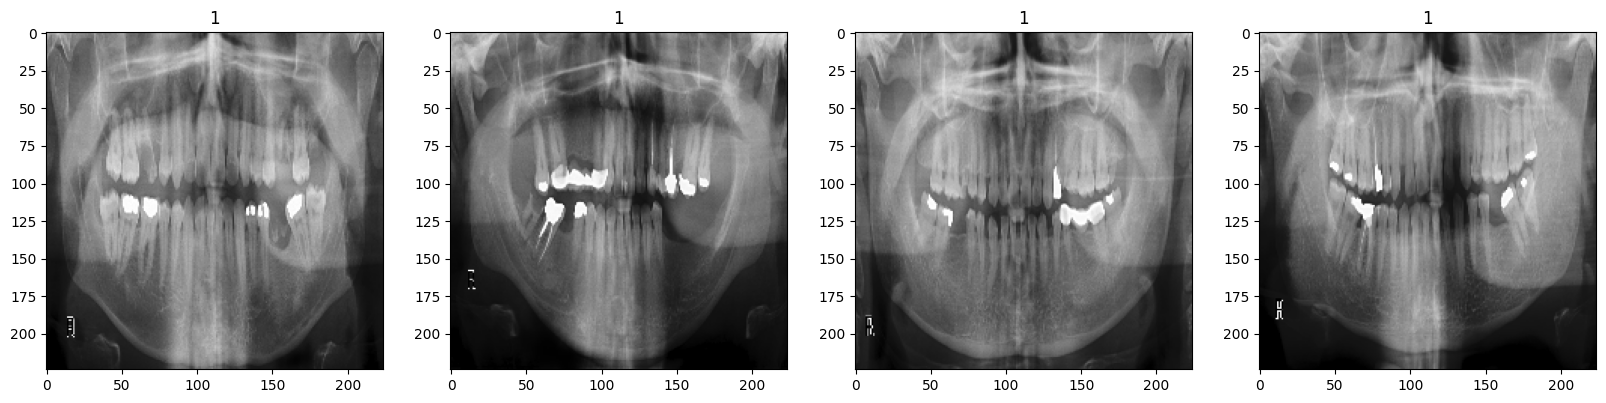

In [ ]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

In [ ]:
batch[0]
batch[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

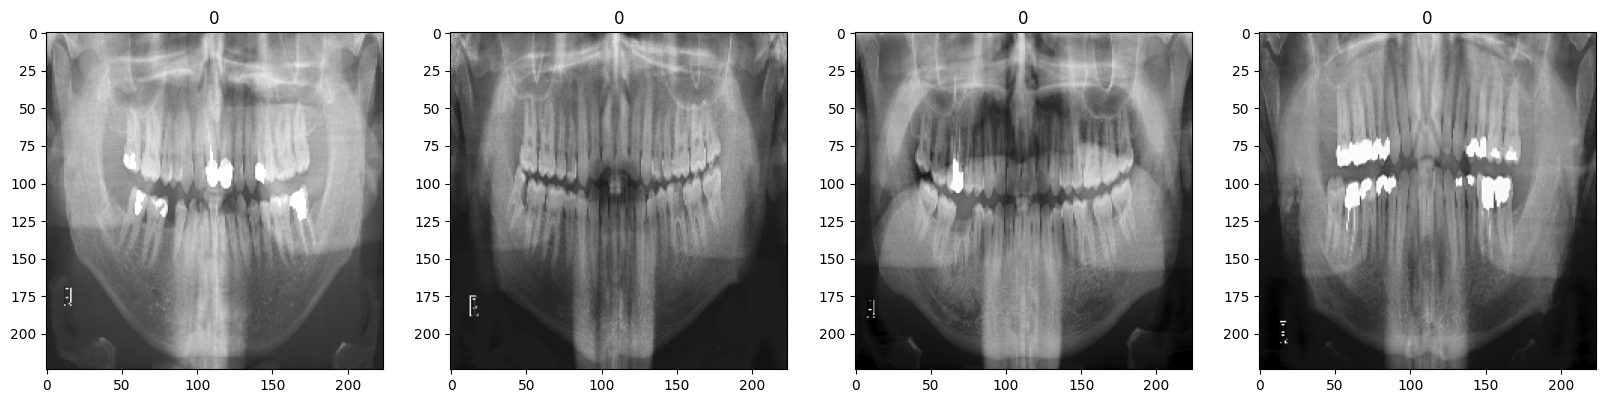

In [ ]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
len(data)

10

In [ ]:
train_size = int(len(data)*.5)
val_size = int(len(data)*.25)
test_size = int(len(data)*.25)

if (train_size+val_size+test_size) != len(data):
  print("Sizes do not match")
else:
  print("Sizes match")

Sizes do not match


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [ ]:
from tensorflow.keras.applications import EfficientNetV2L
pre_trained_model = EfficientNetV2L(include_top = False,
                             pooling = 'avg',
                            weights = 'imagenet')

473176280/473176280 [==============================] - 16s 0us/step


In [ ]:
pre_trained_model.trainable = False
for layer in pre_trained_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
last_output = pre_trained_model.output
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(pre_trained_model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['rescaling[0][0]']              
                                32)                                                           

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
logdir = "logs\\fit\\"

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
def step_decay(epoch):
    initial_lr = 0.0001
    drop_rate = 0.5
    epochs_drop = 10
    new_lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
    return new_lr
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)
hist = model.fit(train,epochs=100,validation_data = val,callbacks = [early_stopping, lr_scheduler])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 128s 3s/step - loss: 0.0000e+00 - acc: 0.4800 - val_loss: 0.0000e+00 - val_acc: 0.5500 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - 7s 1s/step - loss: 0.0000e+00 - acc: 0.5200 - val_loss: 0.0000e+00 - val_acc: 0.3000 - lr: 1.0000e-04
Epoch 3/100
5/5 [==============================] - 7s 1s/step - loss: 0.0000e+00 - acc: 0.5200 - val_loss: 0.0000e+00 - val_acc: 0.4500 - lr: 1.0000e-04
Epoch 4/100
5/5 [==============================] - 8s 1s/step - loss: 0.0000e+00 - acc: 0.4600 - val_loss: 0.0000e+00 - val_acc: 0.6000 - lr: 1.0000e-04
Epoch 5/100
5/5 [==============================] - 7s 1s/step - loss: 0.0000e+00 - acc: 0.6200 - val_loss: 0.0000e+00 - val_acc: 0.4000 - lr: 1.0000e-04
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 0.0000e+00 - acc: 0.5400 - val_loss: 0.0000e+00 - val_acc: 0.6000 - lr: 1.0000e-04
Epoch 7/100
5/5 [==============================] - 7s 1s/step - loss: 0.0000e+00 - acc: 0.50

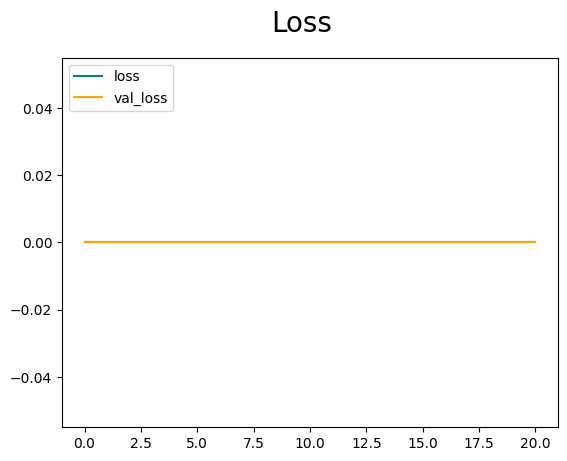

KeyError: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)

1/1 [==============================] - 0s 117ms/step


In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.3333333432674408, Recall:1.0, Accuracy:0.4000000059604645


In [ ]:
import cv2

In [ ]:
img = cv2.imread('test(healthy).jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

error: ignored

In [ ]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

In [ ]:
print(yhat[0][0])

In [ ]:
if (yhat[0][0]) > .5:
  print("Periodontal disease present.")
else:
  print("Periodontal disease absent.")